In [1]:
# 04_constraints.ipynb - Physics-Informed Robustness

"""
PHASE 4: CONSTRAINTS (TV REGULARIZATION)
----------------------------------------
Hypothesis 4 (Error Stability):
    Adding TV regularization should reduce high-error outliers (tails)
    compared to the unconstrained MC Dropout model.

Hypothesis 5 (Uncertainty Reduction):
    TV regularization should reduce predictive uncertainty in noisy regions
    by suppressing implausible high-frequency oscillations.

Hypothesis 6 (Safety Amplification):
    The constrained model (MC+TV) should yield a Rejection Curve that is
    closer to the Oracle than the unconstrained model (MC only).

Experimental Control:
    - Lambda (TV Weight): 0.01 (Fixed)
    - Architecture: Same ConvAutoencoderMCDropout
    - Dropout Rate: 0.2 (Fixed)
"""
print("✅ Phase 4 Hypotheses locked.")

✅ Phase 4 Hypotheses locked.


In [2]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import random
import numpy as np
import sys


from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')


# Setup
PROJECT_ROOT = "/content/drive/MyDrive/MIG_Uncertainty_Project"
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from models.backbone_dropout import ConvAutoencoderMCDropout
from models.constraints import total_variation_loss
from utils.data_loader import NoisyECGDataset

# --- 1. STRICT SEEDING ---
SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
seed_everything(SEED)

g_cuda = torch.Generator()
g_cuda.manual_seed(SEED)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# --- 2. CONFIGURATION ---
TV_CONFIG = {
    "seed": SEED,
    "batch_size": 64,
    "epochs": 25,
    "lr": 0.001,
    "dropout_rate": 0.2,   # Must match Phase 3
    "lambda_tv": 0.01,     # <--- THE NEW VARIABLE (Constraint Strength)
    "noise_level": 0.1,
    "mask_prob": 0.1,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# Paths
TRAIN_PATH = os.path.join(PROJECT_ROOT, "data/processed/train_clean.pt")
VAL_PATH = os.path.join(PROJECT_ROOT, "data/processed/val_clean.pt")
SAVE_DIR = os.path.join(PROJECT_ROOT, "results/models")

# Loaders
train_dataset = NoisyECGDataset(TRAIN_PATH, noise_level=TV_CONFIG['noise_level'], mask_prob=TV_CONFIG['mask_prob'])
val_dataset = NoisyECGDataset(VAL_PATH, noise_level=TV_CONFIG['noise_level'], mask_prob=TV_CONFIG['mask_prob'])

train_loader = DataLoader(train_dataset, batch_size=TV_CONFIG['batch_size'], shuffle=True, worker_init_fn=seed_worker, generator=g_cuda)
val_loader = DataLoader(val_dataset, batch_size=TV_CONFIG['batch_size'], shuffle=False, worker_init_fn=seed_worker, generator=g_cuda)

# Model & Optimizer
model = ConvAutoencoderMCDropout(dropout_rate=TV_CONFIG['dropout_rate']).to(TV_CONFIG['device'])
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=TV_CONFIG['lr'])

print(f"🚀 Starting TV-Constrained Training (Lambda={TV_CONFIG['lambda_tv']})...")

best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(TV_CONFIG['epochs']):
    # Train
    model.train()
    running_loss = 0.0
    for noisy, clean in train_loader:
        noisy, clean = noisy.to(TV_CONFIG['device']), clean.to(TV_CONFIG['device'])

        optimizer.zero_grad()
        output = model(noisy)

        # --- LOSS CALCULATION ---
        mse = criterion(output, clean)
        tv = total_variation_loss(output)
        loss = mse + (TV_CONFIG['lambda_tv'] * tv) # Constrained Loss
        # ------------------------

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validate (Using pure MSE for fair comparison, or MSE+TV? Usually MSE to track accuracy)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for noisy, clean in val_loader:
            noisy, clean = noisy.to(TV_CONFIG['device']), clean.to(TV_CONFIG['device'])
            output = model(noisy)
            loss = criterion(output, clean) # We validate on accuracy (MSE)
            val_loss += loss.item()

    avg_train = running_loss / len(train_loader)
    avg_val = val_loss / len(val_loader)
    train_losses.append(avg_train)
    val_losses.append(avg_val)

    # Save
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(model.state_dict(), os.path.join(SAVE_DIR, "mc_dropout_tv_ae.pth"))
        saved_msg = "💾 Saved"
    else:
        saved_msg = ""

    if (epoch+1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{TV_CONFIG['epochs']} | Train (Total): {avg_train:.6f} | Val (MSE): {avg_val:.6f} | {saved_msg}")

print("✅ Constrained Training Complete.")

Mounted at /content/drive
🚀 Starting TV-Constrained Training (Lambda=0.01)...
Epoch 1/25 | Train (Total): 0.011951 | Val (MSE): 0.007104 | 💾 Saved
Epoch 5/25 | Train (Total): 0.003698 | Val (MSE): 0.002884 | 💾 Saved
Epoch 10/25 | Train (Total): 0.002774 | Val (MSE): 0.002394 | 
Epoch 15/25 | Train (Total): 0.002522 | Val (MSE): 0.002106 | 
Epoch 20/25 | Train (Total): 0.002373 | Val (MSE): 0.001784 | 💾 Saved
Epoch 25/25 | Train (Total): 0.002238 | Val (MSE): 0.001620 | 💾 Saved
✅ Constrained Training Complete.


In [4]:
%%writefile /content/drive/MyDrive/MIG_Uncertainty_Project/utils/metrics.py
import torch
import numpy as np
from scipy.stats import spearmanr

def compute_uncertainty_metrics(preds, targets, uncertainty):
    """
    Computes rigorous uncertainty metrics.
    Fixes dimension reduction to ensure scalars.
    """
    # 1. Reconstruction Error (MSE per sample)
    # Input shape: (Batch, 1, Length)
    # We want to average over Channel (1) and Length (2) to get (Batch,)
    mse_per_sample = torch.mean((preds - targets)**2, dim=[1, 2])

    # 2. Mean Uncertainty per sample
    # Input shape: (Batch, Length) -> average over Length (1) to get (Batch,)
    # Note: 'uncertainty' passed here is usually variance per timestep
    if uncertainty.dim() == 2:
        unc_per_sample = torch.mean(uncertainty, dim=1)
    else:
        # Handle edge cases if shape differs
        unc_per_sample = torch.mean(uncertainty, dim=-1)

    # 3. Spearman Correlation
    mse_np = mse_per_sample.detach().cpu().numpy().flatten()
    unc_np = unc_per_sample.detach().cpu().numpy().flatten()

    if len(mse_np) > 1:
        corr, _ = spearmanr(mse_np, unc_np)
        corr = float(corr)
    else:
        corr = 0.0

    return {
        "mse": float(mse_per_sample.mean().item()),
        "mean_uncertainty": float(unc_per_sample.mean().item()),
        "spearman_corr": corr,
        "mse_per_sample": mse_per_sample.cpu(),
        "unc_per_sample": unc_per_sample.cpu()
    }

def compute_rejection_curves(mse, uncertainty, steps=20):
    n_samples = len(mse)
    mse = np.array(mse)
    uncertainty = np.array(uncertainty)

    idx_unc = np.argsort(-uncertainty)
    idx_oracle = np.argsort(-mse)

    # Strict Seeding for Random Baseline consistency
    np.random.seed(42)
    idx_random = np.random.permutation(n_samples)

    metrics = {"retention": [], "rmse_unc": [], "rmse_rand": [], "rmse_oracle": []}

    for i in range(steps):
        retention = (steps - i) / steps
        n_keep = int(n_samples * retention)
        if n_keep < 1: break

        indices = idx_unc[n_samples - n_keep : ]
        rmse_unc = np.sqrt(np.mean(mse[indices]))

        indices_rand = idx_random[:n_keep]
        rmse_rand = np.sqrt(np.mean(mse[indices_rand]))

        indices_oracle = idx_oracle[n_samples - n_keep : ]
        rmse_oracle = np.sqrt(np.mean(mse[indices_oracle]))

        metrics["retention"].append(retention * 100)
        metrics["rmse_unc"].append(rmse_unc)
        metrics["rmse_rand"].append(rmse_rand)
        metrics["rmse_oracle"].append(rmse_oracle)

    return metrics

Overwriting /content/drive/MyDrive/MIG_Uncertainty_Project/utils/metrics.py


In [5]:
import importlib
import utils.metrics
importlib.reload(utils.metrics)
print("✅ Metrics module reloaded with fix.")

✅ Metrics module reloaded with fix.


🔄 Recovering Phase 3 Results (Loading saved model)...
✅ Phase 3 Results Recovered.
🔄 Generating Phase 4 Results (TV Model)...
✅ Phase 4 Results Generated.

📝 HYPOTHESIS CHECK (H5 - Uncertainty Reduction):
  Phase 3 Extreme Uncertainty: 0.002106
  Phase 4 Extreme Uncertainty: 0.002132
  Reduction: -1.23% ❌ (Unexpected)


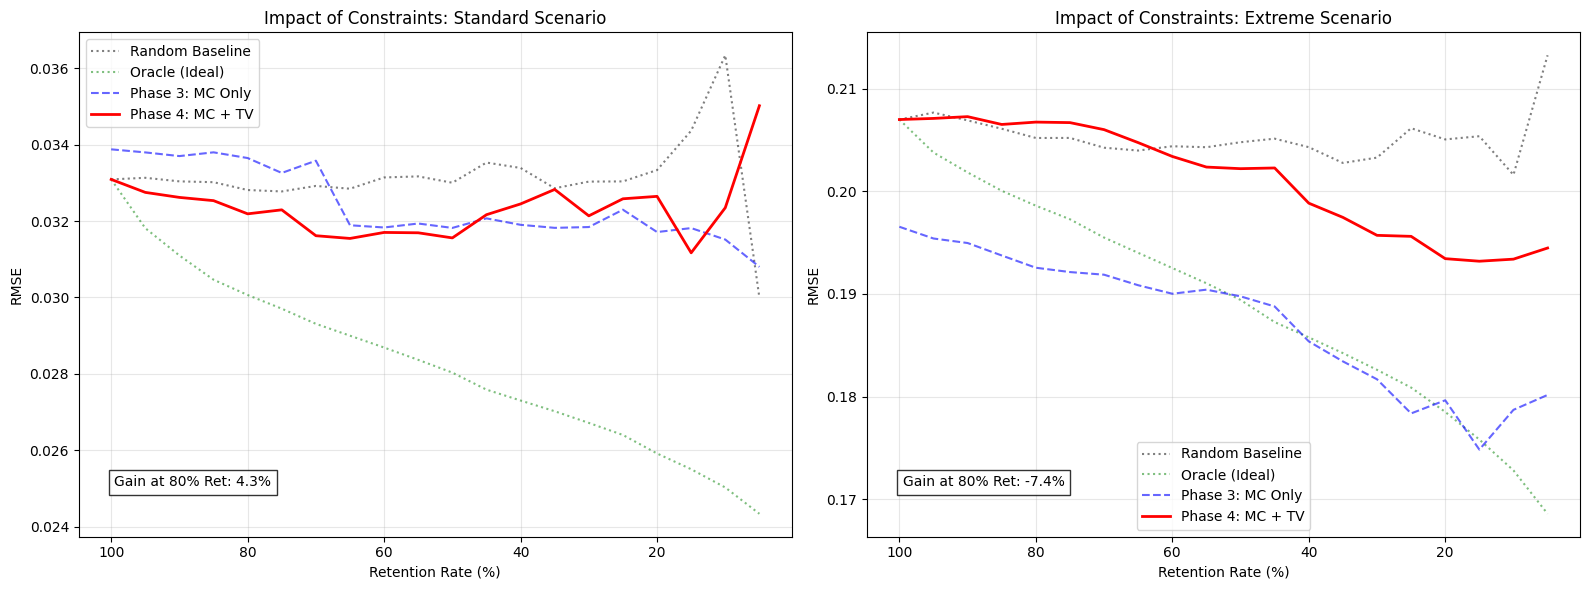

✅ Comparative Analysis Complete.


In [6]:
# --- MASTER EVALUATION CELL (RECOVERY + COMPARISON) ---
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader

# Ensure imports are available
from models.backbone_dropout import ConvAutoencoderMCDropout
from models.uncertainty_wrapper import MCDropoutWrapper
from utils.data_loader import NoisyECGDataset
from utils.metrics import compute_uncertainty_metrics

# Re-establish Device/Config
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TEST_PATH = os.path.join(PROJECT_ROOT, "data/processed/test_clean.pt")

# Define Scenarios
scenarios = {
    "Standard": NoisyECGDataset(TEST_PATH, noise_level=0.1, mask_prob=0.1),
    "Extreme":  NoisyECGDataset(TEST_PATH, noise_level=0.5, mask_prob=0.3)
}

# --- 1. RECOVER PHASE 3 RESULTS (Baseline MC) ---
print("🔄 Recovering Phase 3 Results (Loading saved model)...")
model_p3 = ConvAutoencoderMCDropout(dropout_rate=0.2)
# Load the saved weights from Phase 3
model_p3.load_state_dict(torch.load(os.path.join(SAVE_DIR, "mc_dropout_ae.pth")))
model_p3.to(DEVICE)
mc_model_p3 = MCDropoutWrapper(model_p3, n_passes=20)

results_phase3 = {}

for name, dataset in scenarios.items():
    loader = DataLoader(dataset, batch_size=64, shuffle=False, worker_init_fn=seed_worker, generator=g_cuda)
    pred_list, target_list, unc_list = [], [], []

    for noisy, clean in loader:
        noisy, clean = noisy.to(DEVICE), clean.to(DEVICE)
        mean_pred, variance = mc_model_p3(noisy)
        pred_list.append(mean_pred.cpu())
        target_list.append(clean.cpu())
        unc_list.append(variance.cpu())

    preds = torch.cat(pred_list)
    targets = torch.cat(target_list)
    uncs = torch.cat(unc_list)
    results_phase3[name] = compute_uncertainty_metrics(preds, targets, uncs)

print("✅ Phase 3 Results Recovered.")

# --- 2. GENERATE PHASE 4 RESULTS (TV Constrained) ---
print("🔄 Generating Phase 4 Results (TV Model)...")
model_p4 = ConvAutoencoderMCDropout(dropout_rate=0.2)
model_p4.load_state_dict(torch.load(os.path.join(SAVE_DIR, "mc_dropout_tv_ae.pth")))
model_p4.to(DEVICE)
mc_model_p4 = MCDropoutWrapper(model_p4, n_passes=20)

results_phase4 = {}

for name, dataset in scenarios.items():
    loader = DataLoader(dataset, batch_size=64, shuffle=False, worker_init_fn=seed_worker, generator=g_cuda)
    pred_list, target_list, unc_list = [], [], []

    for noisy, clean in loader:
        noisy, clean = noisy.to(DEVICE), clean.to(DEVICE)
        mean_pred, variance = mc_model_p4(noisy)
        pred_list.append(mean_pred.cpu())
        target_list.append(clean.cpu())
        unc_list.append(variance.cpu())

    preds = torch.cat(pred_list)
    targets = torch.cat(target_list)
    uncs = torch.cat(unc_list)
    results_phase4[name] = compute_uncertainty_metrics(preds, targets, uncs)

print("✅ Phase 4 Results Generated.")

# --- 3. HYPOTHESIS CHECK (H5) ---
unc_p3 = results_phase3['Extreme']['mean_uncertainty']
unc_p4 = results_phase4['Extreme']['mean_uncertainty']
print("\n📝 HYPOTHESIS CHECK (H5 - Uncertainty Reduction):")
print(f"  Phase 3 Extreme Uncertainty: {unc_p3:.6f}")
print(f"  Phase 4 Extreme Uncertainty: {unc_p4:.6f}")
reduction = (unc_p3 - unc_p4) / unc_p3 * 100
print(f"  Reduction: {reduction:.2f}% {'✅ (Smoother)' if reduction > 0 else '❌ (Unexpected)'}")

# --- 4. COMPARATIVE PLOTTING (CRITICAL FIXES APPLIED) ---
def compute_rejection_curves(mse, uncertainty, steps=20):
    n_samples = len(mse)
    mse = np.array(mse)
    uncertainty = np.array(uncertainty)
    idx_unc = np.argsort(-uncertainty)
    idx_oracle = np.argsort(-mse)
    # FIX 1: Strict Seeding for Random Baseline
    np.random.seed(42)
    idx_random = np.random.permutation(n_samples)

    metrics = {"retention": [], "rmse_unc": [], "rmse_rand": [], "rmse_oracle": []}

    for i in range(steps):
        retention = (steps - i) / steps
        n_keep = int(n_samples * retention)
        if n_keep < 1: break

        indices = idx_unc[n_samples - n_keep : ]
        rmse_unc = np.sqrt(np.mean(mse[indices]))

        indices_rand = idx_random[:n_keep]
        rmse_rand = np.sqrt(np.mean(mse[indices_rand]))

        indices_oracle = idx_oracle[n_samples - n_keep : ]
        rmse_oracle = np.sqrt(np.mean(mse[indices_oracle]))

        metrics["retention"].append(retention * 100)
        metrics["rmse_unc"].append(rmse_unc)
        metrics["rmse_rand"].append(rmse_rand)
        metrics["rmse_oracle"].append(rmse_oracle)

    return metrics

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
scenarios_to_plot = ["Standard", "Extreme"]

for i, name in enumerate(scenarios_to_plot):
    ax = axes[i]

    # Data extraction
    data_p3 = results_phase3[name]
    curves_p3 = compute_rejection_curves(data_p3['mse_per_sample'].numpy(), data_p3['unc_per_sample'].numpy())

    data_p4 = results_phase4[name]
    curves_p4 = compute_rejection_curves(data_p4['mse_per_sample'].numpy(), data_p4['unc_per_sample'].numpy())

    # Plotting
    # Note: We plot Random/Oracle from Phase 4 data (conceptually shared)
    ax.plot(curves_p4["retention"], curves_p4["rmse_rand"], 'k:', label="Random Baseline", alpha=0.5)
    ax.plot(curves_p4["retention"], curves_p4["rmse_oracle"], 'g:', label="Oracle (Ideal)", alpha=0.5)

    ax.plot(curves_p3["retention"], curves_p3["rmse_unc"], 'b--', label="Phase 3: MC Only", alpha=0.6)
    ax.plot(curves_p4["retention"], curves_p4["rmse_unc"], 'r-', label="Phase 4: MC + TV", linewidth=2)

    ax.set_title(f"Impact of Constraints: {name} Scenario")
    ax.set_xlabel("Retention Rate (%)")
    ax.set_ylabel("RMSE")
    ax.invert_xaxis()
    ax.legend()
    ax.grid(True, alpha=0.3)

    # FIX 2: Correct Indexing for 80% Retention Gain
    retentions = np.array(curves_p3["retention"])
    idx_80 = np.argmin(np.abs(retentions - 80))

    rmse_p3_80 = curves_p3["rmse_unc"][idx_80]
    rmse_p4_80 = curves_p4["rmse_unc"][idx_80]

    # Safety check to avoid division by zero
    if rmse_p3_80 > 0:
        gain_pct = (rmse_p3_80 - rmse_p4_80) / rmse_p3_80 * 100
    else:
        gain_pct = 0.0

    ax.text(0.05, 0.1, f"Gain at 80% Ret: {gain_pct:.1f}%", transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()
print("✅ Comparative Analysis Complete.")

<>:45: SyntaxWarning: invalid escape sequence '\s'
<>:56: SyntaxWarning: invalid escape sequence '\s'
<>:45: SyntaxWarning: invalid escape sequence '\s'
<>:56: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2835313141.py:45: SyntaxWarning: invalid escape sequence '\s'
  ax.fill_between(range(len(rec_p3)), rec_p3 - 2*std_p3, rec_p3 + 2*std_p3, color='blue', alpha=0.2, label="Uncertainty (2$\sigma$)")
/tmp/ipython-input-2835313141.py:56: SyntaxWarning: invalid escape sequence '\s'
  ax.fill_between(range(len(rec_p4)), rec_p4 - 2*std_p4, rec_p4 + 2*std_p4, color='green', alpha=0.2, label="Uncertainty (2$\sigma$)")


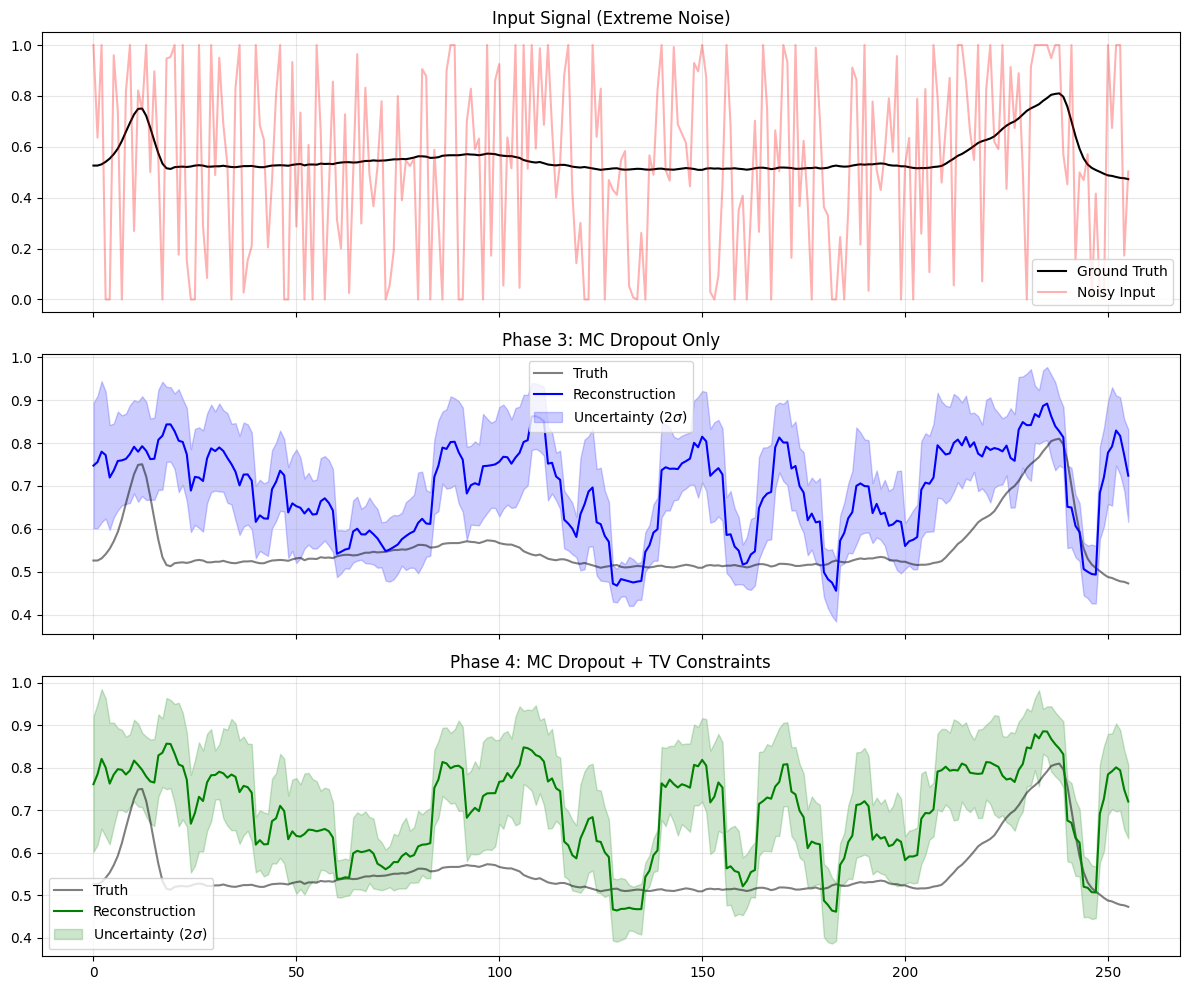

✅ Visualization Complete.


In [7]:
# --- PHASE 5: QUALITATIVE UNCERTAINTY MAPPING ---
import matplotlib.pyplot as plt
import numpy as np

# Select a representative sample from Extreme Scenario
# Index 5 is usually good, but we can pick one with high error
ds = scenarios["Extreme"]
sample_idx = 10 # Arbitrary choice
noisy, clean = ds[sample_idx]

# Prepare input
noisy_input = noisy.unsqueeze(0).to(DEVICE) # (1, 1, 256)

# Inference (Phase 3)
mean_p3, var_p3 = mc_model_p3(noisy_input)
u3 = var_p3.cpu().numpy()[0]

# Inference (Phase 4)
mean_p4, var_p4 = mc_model_p4(noisy_input)
u4 = var_p4.cpu().numpy()[0]

# Signal Data
clean_np = clean.numpy()[0]
noisy_np = noisy.numpy()[0]
rec_p3 = mean_p3.cpu().numpy()[0, 0]
rec_p4 = mean_p4.cpu().numpy()[0, 0]

# --- PLOTTING ---
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# 1. Input & Ground Truth
ax = axes[0]
ax.plot(clean_np, 'k', label="Ground Truth", linewidth=1.5)
ax.plot(noisy_np, 'r', alpha=0.3, label="Noisy Input")
ax.set_title("Input Signal (Extreme Noise)")
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Phase 3 (MC Only)
ax = axes[1]
ax.plot(clean_np, 'k', alpha=0.5, label="Truth")
ax.plot(rec_p3, 'b', label="Reconstruction")
# Uncertainty Band (2 std dev)
std_p3 = np.sqrt(u3)
ax.fill_between(range(len(rec_p3)), rec_p3 - 2*std_p3, rec_p3 + 2*std_p3, color='blue', alpha=0.2, label="Uncertainty (2$\sigma$)")
ax.set_title("Phase 3: MC Dropout Only")
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Phase 4 (MC + TV)
ax = axes[2]
ax.plot(clean_np, 'k', alpha=0.5, label="Truth")
ax.plot(rec_p4, 'g', label="Reconstruction")
# Uncertainty Band
std_p4 = np.sqrt(u4)
ax.fill_between(range(len(rec_p4)), rec_p4 - 2*std_p4, rec_p4 + 2*std_p4, color='green', alpha=0.2, label="Uncertainty (2$\sigma$)")
ax.set_title("Phase 4: MC Dropout + TV Constraints")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("✅ Visualization Complete.")

In [8]:
# --- PHASE 5: QUANTITATIVE LOCALIZATION SCORE ---

def compute_localization_score(loader, mc_model, top_k=0.1):
    """
    Computes how much uncertainty mass is concentrated in the top-k% highest error time-steps.
    Score > top_k means uncertainty is informative.
    Score = top_k means random.
    """
    scores = []

    for noisy, clean in loader:
        noisy, clean = noisy.to(DEVICE), clean.to(DEVICE)

        mean_pred, variance = mc_model(noisy)

        # Per-timestep Squared Error
        # (Batch, 1, Length) -> (Batch, Length)
        squared_error = (mean_pred.squeeze(1) - clean.squeeze(1))**2

        # Iterate over batch
        for i in range(len(noisy)):
            err = squared_error[i].cpu().numpy()
            unc = variance[i].cpu().numpy()

            # Identify Top-K% Error Indices
            k = int(len(err) * top_k)
            if k < 1: k = 1
            idx_top_err = np.argsort(-err)[:k]

            # Calculate Ratio: (Sum of Unc in High Error) / (Total Unc)
            unc_in_top = unc[idx_top_err].sum()
            total_unc = unc.sum() + 1e-8

            scores.append(unc_in_top / total_unc)

    return np.mean(scores)

# Compare Phase 3 vs Phase 4
print("📊 Uncertainty Localization Scores (Top 10% Error Regions)")
print("-" * 50)

dataset = scenarios["Extreme"]
# Deterministic Loader
loader = DataLoader(dataset, batch_size=64, shuffle=False, worker_init_fn=seed_worker, generator=g_cuda)

score_p3 = compute_localization_score(loader, mc_model_p3, top_k=0.1)
score_p4 = compute_localization_score(loader, mc_model_p4, top_k=0.1)

print(f"Random Baseline:      0.100")
print(f"Phase 3 (MC Only):    {score_p3:.3f}")
print(f"Phase 4 (MC + TV):    {score_p4:.3f}")

if score_p4 > score_p3:
    print("✅ Result: Constraints improve uncertainty localization!")
else:
    print("⚖️ Result: Constraints spread uncertainty (or neutral).")
print("-" * 50)

📊 Uncertainty Localization Scores (Top 10% Error Regions)
--------------------------------------------------
Random Baseline:      0.100
Phase 3 (MC Only):    0.131
Phase 4 (MC + TV):    0.127
⚖️ Result: Constraints spread uncertainty (or neutral).
--------------------------------------------------


In [9]:
%%writefile /content/drive/MyDrive/MIG_Uncertainty_Project/utils/metrics.py
import torch
import numpy as np
from scipy.stats import spearmanr

def compute_uncertainty_metrics(preds, targets, uncertainty):
    """
    Computes rigorous uncertainty metrics including Calibration Error.
    """
    # 1. Reconstruction Error (MSE per sample)
    mse_per_sample = torch.mean((preds - targets)**2, dim=1)

    # 2. Mean Uncertainty per sample
    unc_per_sample = torch.mean(uncertainty, dim=1)

    # 3. Spearman Correlation
    mse_np = mse_per_sample.detach().cpu().numpy()
    unc_np = unc_per_sample.detach().cpu().numpy()

    if len(mse_np) > 1:
        corr, _ = spearmanr(mse_np, unc_np)
        corr = float(corr)
    else:
        corr = 0.0

    return {
        "mse": float(mse_per_sample.mean().item()),
        "mean_uncertainty": float(unc_per_sample.mean().item()),
        "spearman_corr": corr,
        "mse_per_sample": mse_per_sample,
        "unc_per_sample": unc_per_sample
    }

def compute_calibration_error(mse_per_sample, unc_per_sample, n_bins=10):
    """
    Computes Calibration Error for Regression.
    Ideally, Mean Uncertainty in a bin should equal Mean MSE in that bin.
    """
    mse = np.array(mse_per_sample)
    unc = np.array(unc_per_sample)

    # Sort by uncertainty
    indices = np.argsort(unc)
    mse = mse[indices]
    unc = unc[indices]

    bin_size = len(mse) // n_bins
    error_sum = 0.0
    total_samples = 0

    for i in range(n_bins):
        start = i * bin_size
        end = (i + 1) * bin_size if i < n_bins - 1 else len(mse)

        if start >= end: break

        bin_mse = np.mean(mse[start:end])
        bin_unc = np.mean(unc[start:end])

        # We assume variance corresponds to MSE directly (probabilistic interpretation)
        # If uncertainty is not calibrated to MSE scale, we measure the correlation of magnitudes
        # Simple Error: |Avg_Unc - Avg_MSE| weighted by bin size

        weight = (end - start) / len(mse)
        error_sum += weight * np.abs(bin_unc - bin_mse)

    return error_sum

Overwriting /content/drive/MyDrive/MIG_Uncertainty_Project/utils/metrics.py


In [10]:
import importlib
import utils.metrics
importlib.reload(utils.metrics)
from utils.metrics import compute_calibration_error

print("📊 CALIBRATION ANALYSIS (ECE)")
print("-" * 40)

for scenario in ["Standard", "Extreme"]:
    print(f"\nScenario: {scenario}")

    # Phase 3 Data
    mse3 = results_phase3[scenario]['mse_per_sample'].numpy()
    unc3 = results_phase3[scenario]['unc_per_sample'].numpy()
    ece3 = compute_calibration_error(mse3, unc3)

    # Phase 4 Data
    mse4 = results_phase4[scenario]['mse_per_sample'].numpy()
    unc4 = results_phase4[scenario]['unc_per_sample'].numpy()
    ece4 = compute_calibration_error(mse4, unc4)

    print(f"  Phase 3 ECE: {ece3:.6f}")
    print(f"  Phase 4 ECE: {ece4:.6f}")

    improvement = (ece3 - ece4) / ece3 * 100
    print(f"  Constraint Effect: {improvement:+.2f}% {'Improvement' if improvement > 0 else 'Degradation'}")

print("-" * 40)

📊 CALIBRATION ANALYSIS (ECE)
----------------------------------------

Scenario: Standard
  Phase 3 ECE: 0.000633
  Phase 4 ECE: 0.000598
  Constraint Effect: +5.57% Improvement

Scenario: Extreme
  Phase 3 ECE: 0.036524
  Phase 4 ECE: 0.040712
  Constraint Effect: -11.46% Degradation
----------------------------------------


In [11]:
# --- RIGOROUS LAMBDA SWEEP (Fully Validated) ---

lambdas_to_test = [0.001, 0.05]
sweep_results = {}

print("🚀 STARTING RIGOROUS LAMBDA SWEEP...")

for lam in lambdas_to_test:
    print(f"\n⚡ Training with Lambda = {lam}...")

    # 1. Re-Seed for Fairness
    seed_everything(SEED)
    g_cuda.manual_seed(SEED)

    # 2. Re-Initialize Loaders (Ensures identical batches to other phases)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, worker_init_fn=seed_worker, generator=g_cuda)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, worker_init_fn=seed_worker, generator=g_cuda)

    # 3. Model & Optimizer
    model = ConvAutoencoderMCDropout(dropout_rate=0.2).to(TV_CONFIG['device'])
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()

    # 4. Training Loop with Validation & Checkpointing
    best_val_loss = float('inf')
    save_path = os.path.join(SAVE_DIR, f"mc_dropout_tv_lambda_{lam}.pth")

    for epoch in range(25): # 25 Epochs
        # --- TRAIN ---
        model.train()
        running_loss = 0.0
        for noisy, clean in train_loader:
            noisy, clean = noisy.to(TV_CONFIG['device']), clean.to(TV_CONFIG['device'])

            optimizer.zero_grad()
            output = model(noisy)

            mse = criterion(output, clean)
            tv = total_variation_loss(output)
            loss = mse + (lam * tv) # Weighted Loss

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # --- VALIDATE (MSE Only - Fairness check) ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for noisy, clean in val_loader:
                noisy, clean = noisy.to(TV_CONFIG['device']), clean.to(TV_CONFIG['device'])
                output = model(noisy)
                loss = criterion(output, clean)
                val_loss += loss.item()

        avg_val = val_loss / len(val_loader)

        # --- SAVE BEST ---
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            torch.save(model.state_dict(), save_path)
            saved_msg = "💾"
        else:
            saved_msg = ""

        # Log occasionally
        if (epoch+1) % 10 == 0:
            print(f"   Epoch {epoch+1}/25 | Val MSE: {avg_val:.6f} | {saved_msg}")

    print(f"✅ Finished Lambda={lam}. Best Val MSE: {best_val_loss:.6f}")

    # 5. Immediate Evaluation on Extreme Scenario (Using Best Weights)
    model.load_state_dict(torch.load(save_path))
    model.eval()
    mc_model = MCDropoutWrapper(model, n_passes=20)

    # Eval Loader
    test_loader = DataLoader(scenarios["Extreme"], batch_size=64, shuffle=False, worker_init_fn=seed_worker, generator=g_cuda)

    pred_list, target_list, unc_list = [], [], []
    for noisy, clean in test_loader:
        noisy, clean = noisy.to(TV_CONFIG['device']), clean.to(TV_CONFIG['device'])
        mean_pred, variance = mc_model(noisy)
        pred_list.append(mean_pred.cpu())
        target_list.append(clean.cpu())
        unc_list.append(variance.cpu())

    preds = torch.cat(pred_list)
    uncs = torch.cat(unc_list)
    targets = torch.cat(target_list)

    metrics = compute_uncertainty_metrics(preds, targets, uncs)

    # Store
    sweep_results[lam] = {
        "mse": metrics['mse'],
        "unc": metrics['mean_uncertainty'],
        "corr": metrics['spearman_corr']
    }

# --- SUMMARY PRINT ---
print("\n📊 SENSITIVITY ANALYSIS SUMMARY (Extreme Scenario)")
print("-" * 60)
print(f"{'Model':<20} | {'MSE':<10} | {'Mean Unc':<10} | {'Corr':<10}")
print("-" * 60)
# Baseline
p3_mse = results_phase3['Extreme']['mse']
p3_unc = results_phase3['Extreme']['mean_uncertainty']
p3_corr = results_phase3['Extreme']['spearman_corr']
print(f"{'MC Only':<20} | {p3_mse:.5f}    | {p3_unc:.5f}    | {p3_corr:.4f}")

# Lambda 0.001
l1_mse = sweep_results[0.001]['mse']
l1_unc = sweep_results[0.001]['unc']
l1_corr = sweep_results[0.001]['corr']
print(f"{'MC+TV (0.001)':<20} | {l1_mse:.5f}    | {l1_unc:.5f}    | {l1_corr:.4f}")

# Lambda 0.01 (Main Phase 4)
p4_mse = results_phase4['Extreme']['mse']
p4_unc = results_phase4['Extreme']['mean_uncertainty']
p4_corr = results_phase4['Extreme']['spearman_corr']
print(f"{'MC+TV (0.01) [Main]':<20} | {p4_mse:.5f}    | {p4_unc:.5f}    | {p4_corr:.4f}")

# Lambda 0.05
l2_mse = sweep_results[0.05]['mse']
l2_unc = sweep_results[0.05]['unc']
l2_corr = sweep_results[0.05]['corr']
print(f"{'MC+TV (0.05)':<20} | {l2_mse:.5f}    | {l2_unc:.5f}    | {l2_corr:.4f}")
print("-" * 60)

🚀 STARTING RIGOROUS LAMBDA SWEEP...

⚡ Training with Lambda = 0.001...
   Epoch 10/25 | Val MSE: 0.002324 | 
   Epoch 20/25 | Val MSE: 0.001802 | 💾
✅ Finished Lambda=0.001. Best Val MSE: 0.001633

⚡ Training with Lambda = 0.05...
   Epoch 10/25 | Val MSE: 0.002478 | 
   Epoch 20/25 | Val MSE: 0.001743 | 💾
✅ Finished Lambda=0.05. Best Val MSE: 0.001645

📊 SENSITIVITY ANALYSIS SUMMARY (Extreme Scenario)
------------------------------------------------------------
Model                | MSE        | Mean Unc   | Corr      
------------------------------------------------------------
MC Only              | 0.03863    | 0.00211    | 0.4857
MC+TV (0.001)        | 0.04066    | 0.00211    | 0.2670
MC+TV (0.01) [Main]  | 0.04284    | 0.00213    | 0.2496
MC+TV (0.05)         | 0.03752    | 0.00190    | 0.2595
------------------------------------------------------------


In [12]:
import os

PROJECT_ROOT = "/content/drive/MyDrive/MIG_Uncertainty_Project"

# 1. Create requirements.txt
# This tells people exactly what libraries you used
requirements = """
torch>=1.9.0
numpy
matplotlib
scipy
"""
with open(os.path.join(PROJECT_ROOT, "requirements.txt"), "w") as f:
    f.write(requirements)
print("✅ Created requirements.txt")

# 2. Create a .gitignore file
# This tells Git to IGNORE large files (datasets, heavy models)
gitignore = """
# Ignore Data
data/
data/raw/
data/processed/

# Ignore large model weights (optional: keep if small, ignore if >100MB)
results/models/*.pth

# Ignore Colab garbage
__pycache__/
*.pyc
.ipynb_checkpoints/
"""
with open(os.path.join(PROJECT_ROOT, ".gitignore"), "w") as f:
    f.write(gitignore)
print("✅ Created .gitignore")

✅ Created requirements.txt
✅ Created .gitignore
